In [222]:
fname = 'data\\from-azure\\mapf_dims_64_epochs_3_lr_0.1_embeddings.txt'
label_fname = 'data\\from-azure\\mapf.Labels'

In [223]:
import pandas as pd

df = pd.read_csv('data/from-azure/AllData-labelled-withbridges.csv')


In [224]:
def coverage_score(df, preds):
    solved = 0
    for pred, (index, row) in zip(preds,df.iterrows()):
        if(row[pred] < 300000):
              solved += 1
    return solved/len(df)

def cumsum_score(df, preds):
    cumsum = 0
    for pred, (index, row) in zip(preds,df.iterrows()):
        cumsum += row[pred]
    return cumsum/((60*(10**3)))


In [225]:
def round_up_to_5(num):
    return str(5 - (int(num) % 5) + int(num))

def obstacle_density_to_num(density):
    if density=='0.0':
        return 0
    density = density.split('.')[1]
    if len(density) > 2:
        return round_up_to_5(density[:2])
    elif density[0] == '0':
        return density[1:]
    elif len(density) == 1:
        return density+'0'

    return density


In [226]:
def file_name_from(row):
    if row.GridName == 'Unknown':
        data = ['Instance',row.GridRows, obstacle_density_to_num(str(row.ObstacleDensity)), row.NumOfAgents, row.InstanceId]
        line = '-'.join(map(str, data)) + '.gexf' 
    else:
        data = [row.GridName, str(row.NumOfAgents), str(row.InstanceId)]
        line = '-'.join(map(str,data)) +'.gexf' 
    return line

In [227]:
df['mapf_file'] = df.apply(lambda x: file_name_from(x),axis=1)

In [228]:
mapf_df = pd.read_csv(label_fname,delim_whitespace=True, header=None, names=['mapf_file','label','embedding'], )

In [229]:
import json
with open(fname,'r') as fh:
    graph_embedding_dict = json.load(fh)

In [230]:
graph_embedding_dict = dict([(k.split('\\')[4].split('.g2v3')[0],v) for k,v in graph_embedding_dict.items()])

In [231]:
mapf_df = mapf_df.merge(df, on=['mapf_file'])

In [232]:
def embedding_for(file):
    if file in graph_embedding_dict:
        embedding = graph_embedding_dict[file]
    else:
        embedding =  [0]*64
    embedding = np.array(embedding)
    return embedding

In [233]:
import numpy as np
embedding_cols = ['embedding'+str(x) for x in range(1,65)]
train_word2vec_df=pd.DataFrame([[k]+v for k,v in graph_embedding_dict.items()],columns=['mapf_file'] + embedding_cols)

In [234]:
merged_df = mapf_df.merge(train_word2vec_df, on=['mapf_file'])

In [235]:
conversions = {
        0 : 'EPEA*+ID Runtime',
        1 : 'MA-CBS-Global-10/(EPEA*/SIC) choosing the first conflict in CBS nodes Runtime',
        2 : 'ICTS 3E +ID Runtime',
        3 : 'A*+OD+ID Runtime',
        4 : 'Basic-CBS/(A*/SIC)+ID Runtime'
    }

In [236]:
def suffix_from_label(label):
    return {
        'EPEA*+ID Runtime': 0,
        'MA-CBS-Global-10/(EPEA*/SIC) choosing the first conflict in CBS nodes Runtime':1,
        'ICTS 3E +ID Runtime':2,
        'A*+OD+ID Runtime':3,
        'Basic-CBS/(A*/SIC)+ID Runtime':4
    }[label]

In [237]:
merged_df['label'] =merged_df.apply(lambda x: conversions[x['label']], axis=1)

In [238]:
def func(x):
    return np.log1p(x)
def inverse_func(x):
    return np.expm1(x)

In [239]:
runtime_cols = ['EPEA*+ID Runtime',
                'MA-CBS-Global-10/(EPEA*/SIC) choosing the first conflict in CBS nodes Runtime',
                'ICTS 3E +ID Runtime',
                'A*+OD+ID Runtime',
                'Basic-CBS/(A*/SIC)+ID Runtime',
                'Y Runtime']

alg_runtime_cols = runtime_cols.copy()
if 'P Runtime' in alg_runtime_cols:
    alg_runtime_cols.remove('P Runtime')
    
only_alg_runtime_cols = alg_runtime_cols.copy()
only_alg_runtime_cols.remove('Y Runtime')

In [240]:
train_samples_weight = X_train.apply(lambda x: np.log10(np.std(x[only_alg_runtime_cols].values)), axis=1)

In [244]:
from sklearn.compose import TransformedTargetRegressor

xg_regs = []
regs_data = []
index = 0
for runtime_col in runtime_cols:
    if 'P Runtime' in runtime_col or 'Y Runtime' in runtime_col:
        continue
    print(index,":",runtime_col)
    index += 1
    regs_data.append([X_train[embedding_cols + features_cols],X_test[embedding_cols + features_cols], X_train[runtime_col], X_test[runtime_col]])
    xg_reg = xgb.XGBRegressor(objective ='reg:linear', min_child_weight=0.5, colsample_bytree = 0.8, learning_rate = 0.1
                              , max_depth = 3,alpha = 10, n_estimators = 75)#, colsample_bylevel= 0.5, colsample_bynode = 0.5)
    xg_reg_trans = TransformedTargetRegressor(regressor=xg_reg, func=func, inverse_func=inverse_func)
    
    xg_reg_trans.fit(X_train[embedding_cols + features_cols], X_train[runtime_col],sample_weight=train_samples_weight )
    
    xg_regs.append(xg_reg_trans)



0 : EPEA*+ID Runtime


c:\users\omri\appdata\local\programs\python\python36\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


1 : MA-CBS-Global-10/(EPEA*/SIC) choosing the first conflict in CBS nodes Runtime


c:\users\omri\appdata\local\programs\python\python36\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


2 : ICTS 3E +ID Runtime


c:\users\omri\appdata\local\programs\python\python36\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


3 : A*+OD+ID Runtime


c:\users\omri\appdata\local\programs\python\python36\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


4 : Basic-CBS/(A*/SIC)+ID Runtime


c:\users\omri\appdata\local\programs\python\python36\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [245]:
import numpy as np

from sklearn.metrics import mean_squared_error, median_absolute_error, mean_absolute_error

rmses = []
for xg_reg, reg_data in zip(xg_regs, regs_data):
    print("test label mean", np.std(reg_data[3]))
    reg_train_preds = xg_reg.predict(reg_data[0])
    reg_test_preds = xg_reg.predict(reg_data[1])
    print("Train acc:",np.sqrt(mean_squared_error(reg_data[2], reg_train_preds)))
    rmses.append(np.sqrt(mean_squared_error(reg_data[3], reg_test_preds)))
    print("Test acc:",np.sqrt(mean_squared_error(reg_data[3], reg_test_preds)))


test label mean 96981.07786000965
Train acc: 77109.4352131851
Test acc: 83245.9779951779
test label mean 138062.52697224042
Train acc: 107019.5460780695
Test acc: 113630.17286198243
test label mean 91129.20677488472
Train acc: 75529.57799305426
Test acc: 79311.8501450528
test label mean 102764.51548231438
Train acc: 81563.0180156512
Test acc: 86940.55455273371
test label mean 122168.9170349754
Train acc: 106697.52349670797
Test acc: 113002.9405380942


[380441.22, 355012.47, 525642.5, 477426.72, 426056.62, 683103.06, 376627.3, 523210.38, 313457.2, 529826.8, 886187.5] EPEA*+ID Runtime
[390777.6, 454145.7, 429155.47, 319296.22, 322209.25, 378432.56, 307601.1, 428964.78, 365608.25, 335004.38, 537845.6, 383921.25, 397723.4, 457653.03, 323095.44, 336612.7, 473111.34, 440139.06, 419924.28, 372246.2, 322032.9, 311734.7, 370229.6, 325542.88, 543864.44, 453886.75, 402839.03, 475868.0, 394108.16, 437291.9, 448806.78, 320764.88, 344789.22, 336807.94, 302885.3, 355363.4, 410249.16, 380031.1, 305559.72, 372586.44, 324729.88, 314905.6, 448873.53, 520430.03, 333153.94, 398826.8, 378958.03, 321184.25, 394192.72, 367654.75, 372261.1, 335307.72, 302023.75, 410319.6, 300986.0, 379457.8, 427605.47, 360470.75, 339435.62, 425477.2, 333009.1, 322398.6, 335403.97, 330128.44, 367228.28, 379431.75, 399422.5, 315994.3, 348371.75, 324013.75, 365444.06, 307133.28, 411918.47, 326265.5, 348995.9, 470009.66, 351799.53, 350043.9, 326680.22, 410989.28, 335614.53, 323

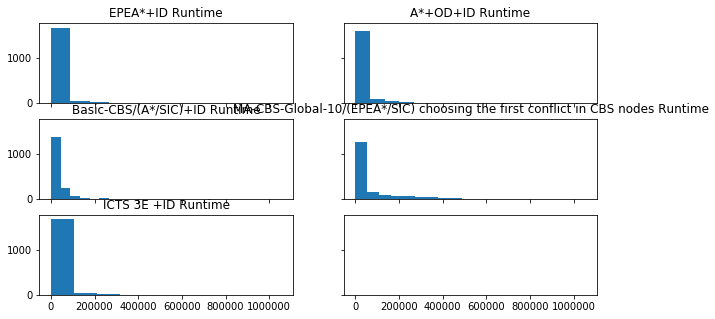

In [246]:
fig, axes = plt.subplots(3, 2, sharey=True, sharex=True, figsize=(10,5))
index =0

for xg_reg, reg_data in zip(xg_regs, regs_data):
    reg_test_preds = xg_reg.predict(reg_data[1])
    print([p for p in reg_test_preds if p > 300000], conversions[index])
    axes[index%3][index%2].hist(reg_test_preds)
    axes[index%3][index%2].set_title(conversions[index])
    index += 1

In [247]:
xg_test_res = []
xg_train_res = []
xg_y = []
for xg_reg in xg_regs:
    xg_test_res.append(np.array(xg_reg.predict(X_test[embedding_cols + features_cols])))
    xg_train_res.append(np.array(xg_reg.predict(X_train[embedding_cols + features_cols])))
xg_test_res = np.array(xg_test_res)
xg_train_res = np.array(xg_train_res)

# print(xg_res.argmin(axis=0)[:4], xg_res[:,:4]) #SANITY CHECK

train_preds = [conversions[index] for index in xg_train_res.argmin(axis=0)]
test_preds = [conversions[index] for index in xg_test_res.argmin(axis=0)]
print("Regressors argmax Train acc:",accuracy_score(y_train, train_preds))
print("Regressors argmax Test acc:",accuracy_score(y_test, test_preds ))
print("Regressors argmax Test coverage:", coverage_score(X_test, test_preds))
print("Regressors argmax Test cumsum:", cumsum_score(X_test, test_preds))

Regressors argmax Train acc: 0.5555555555555556
Regressors argmax Test acc: 0.4673913043478261
Regressors argmax Test coverage: 0.8775743707093822
Regressors argmax Test cumsum: 1337.6441951016745


In [248]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

features_cols = ['GridSize', 'NumOfObstacles',
            'AvgDistanceToGoal', 'MaxDistanceToGoal', 'MinDistanceToGoal', 'AvgStartDistances', 'AvgGoalDistances',
            'NumOfAgents', 'ObstacleDensity', 'PointsAtSPRatio', 'Sparsity',
                 'bridges']

X_train, X_test, y_train, y_test = train_test_split(merged_df, merged_df['label'], test_size=0.3)
xg_cls = xgb.XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.01)
xg_cls.fit(X_train[embedding_cols + features_cols], y_train, sample_weight=train_samples_weight)


c:\users\omri\appdata\local\programs\python\python36\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [249]:
train_preds = xg_cls.predict(X_train[embedding_cols + features_cols])
test_preds = xg_cls.predict(X_test[embedding_cols + features_cols])

In [250]:
from sklearn.metrics import accuracy_score

print("Train acc:",accuracy_score(y_train, train_preds))
print("Test acc:",accuracy_score(y_test, test_preds))

print("Train coverage:", coverage_score(X_train, train_preds))
print("Test coverage:", coverage_score(X_test, test_preds))

print("Train cumsum:", cumsum_score(X_train, train_preds))
print("Test cumsum:", cumsum_score(X_test, test_preds))

Train acc: 0.7098356634780476
Test acc: 0.5818077803203662
Train coverage: 0.8322295805739515
Test coverage: 0.8049199084668193
Train cumsum: 4021.0767030116644
Test cumsum: 1981.5426575250087


In [205]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2).fit_transform(X_train[ embedding_cols])

In [206]:
def color_from_label(label):
    return {
        'EPEA*+ID Runtime': 'blue',
        'MA-CBS-Global-10/(EPEA*/SIC) choosing the first conflict in CBS nodes Runtime':'red',
        'ICTS 3E +ID Runtime':'green',
        'A*+OD+ID Runtime':'brown',
        'Basic-CBS/(A*/SIC)+ID Runtime':'grey'
    }[label]

colors = [color_from_label(x) for x in X_train['label']]

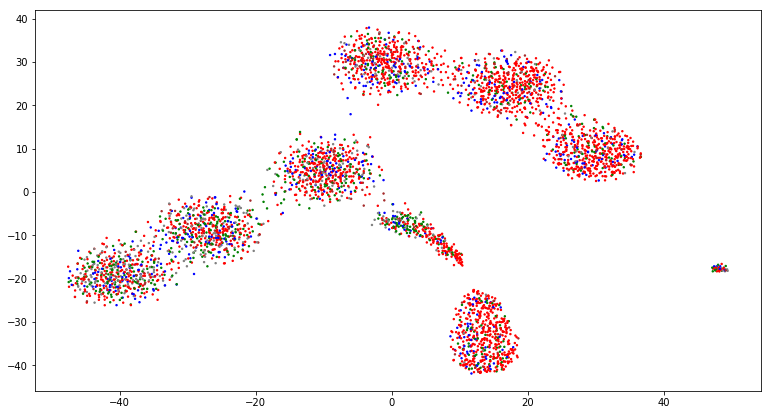

In [207]:
import matplotlib.pyplot as plt

%matplotlib inline
plt.figure(figsize=(13,7))

x_coords = X_embedded[:, 0]
y_coords = X_embedded[:, 1]
# display scatter plot
plt.scatter(x_coords, y_coords, color=colors, s=2)
# for label, x, y in zip(X_train['Y'].values, x_coords, y_coords):
#     plt.annotate(suffix_from_label(label), xy=(x, y), xytext=(0, 0), fontsize=8)
    

In [220]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler

db = DBSCAN(eps=0.3, min_samples=20).fit(X_train[embedding_cols])
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

In [221]:
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(y_train, labels))
print("Completeness: %0.3f" % metrics.completeness_score(y_train, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(y_train, labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(y_train, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(y_train, labels,
                                           average_method='arithmetic'))


Estimated number of clusters: 0
Estimated number of noise points: 4077
Homogeneity: -0.000
Completeness: 1.000
V-measure: -0.000
Adjusted Rand Index: 0.000
Adjusted Mutual Information: -0.000


In [255]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=0).fit(X_train[embedding_cols])

In [256]:
labels = kmeans.labels_
print("Homogeneity: %0.3f" % metrics.homogeneity_score(y_train, labels))
print("Completeness: %0.3f" % metrics.completeness_score(y_train, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(y_train, labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(y_train, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(y_train, labels,
                                           average_method='arithmetic'))

Homogeneity: 0.046
Completeness: 0.039
V-measure: 0.042
Adjusted Rand Index: 0.012
Adjusted Mutual Information: 0.041


In [260]:
from sklearn.cluster import KMeans
pca = PCA(n_components=5).fit(X_train[embedding_cols])
kmeans = KMeans(init=pca.components_, n_clusters=5, random_state=0).fit(X_train[embedding_cols])

c:\users\omri\appdata\local\programs\python\python36\lib\site-packages\sklearn\cluster\k_means_.py:971: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)


In [261]:
labels = kmeans.labels_
print("Homogeneity: %0.3f" % metrics.homogeneity_score(y_train, labels))
print("Completeness: %0.3f" % metrics.completeness_score(y_train, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(y_train, labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(y_train, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(y_train, labels,
                                           average_method='arithmetic'))

Homogeneity: 0.048
Completeness: 0.043
V-measure: 0.045
Adjusted Rand Index: 0.018
Adjusted Mutual Information: 0.044


In [125]:
kmeans_preds = [conversions[p] for p in kmeans.predict(X_test[embedding_cols])]
accuracy_score(kmeans_preds, y_test)
print("Kmeans coverage:", coverage_score(X_test, kmeans_preds))


Kmeans coverage: 0.835812356979405
